In [1]:
import mori_zwanzig as mz
from sklearn.linear_model import LinearRegression
import numpy as np
import time as tm
from collections import defaultdict
import concurrent.futures as cf
from IPython.display import clear_output
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import pickle

In [7]:
particle_mass = 80. # mass of the big particle (the small particles have unit mass)
dt = 0.005          # delta time
seed = 1098340      # seed for rng
kB = 1.             # constant Boltsman
T = 1.              # temperature
Omega = 0.          # Omega value
num_bootstraps = 16 # number of bootstraps
cutoffs = np.arange(1,29.)   # possible kernel cutoff times

# loading in velocity and force data. calculate a time array for later plotting.
v = np.load('velocities.npy')
F = np.load('forces.npy')
sq_displacement = np.load('sq_displacement_stat.npy')
num_steps, num_sims, num_dimensions = v.shape
steps_to_integrate = num_steps
time = np.linspace(0, dt*num_steps, num_steps)

# Parameters for computing D with the Einstein method
start_fit_time = 24.
end_fit_time = 28.
start_fit_index = np.argmin(np.abs(time - start_fit_time))
end_fit_index = np.argmin(np.abs(time - end_fit_time))

# With multiprocessing
start = tm.time()
with cf.ProcessPoolExecutor() as exe:
    future_vacf = exe.submit(mz.compute_correlation_functions, v,None,True,False,False)
    future_Facf = exe.submit(mz.compute_correlation_functions, F,None,True,False,False)
    future_vFcross = exe.submit(mz.compute_correlation_functions, v,F,True,False,False)
    
    v_acf = future_vacf.result()
    F_acf = future_Facf.result()
    vF_cross = future_vFcross.result()
    
print(f"multiprocessing took {(round((tm.time()-start)/60,2))} mins to finish correlation functions")    

multiprocessing took 9.49 mins to finish correlation functions


In [30]:
def GenSamples(num,seed):
    """
    Generates a 'num' amount of samples and returns the results as a list of all the samples.
    
    args:
    num = The resulting number of samples
    seed = The seed for randomizing
    """
    np.random.seed(seed)
    
    list_ = []
    for _ in range(num):
        list_.append((_+1,list(np.random.choice(range(num_sims), size = num_sims, 
                                      replace = True))))
    
    list_ = np.array(list_,dtype=object)
    return list_

In [10]:
def EvenSplit(list_, chunk):
    """
    The Function takes in a list of even length and splits it into an even number of chunks.
    
    args:
    list_ = The list to split
    chunk = The number of chunks to split into
    """
    if len(list_) % 2 == 0 and chunk % 2 == 0:
        list_ = np.array_split(list_, chunk)
        return [i for i in list_]
    else:
        raise ValueError("The list can't be split evenly into an even number." 
                         + " Check its length and the requested chunk size, both should be even.")

In [11]:
def diffusion_constant_from_MSD(start_fit_index, end_fit_index, sample):
    print("Started")
    dict_ = dict()
    msd = np.mean(sq_displacement[:, sample[1], :], axis=(1,2))
    model = LinearRegression()
    model.fit(time[start_fit_index:end_fit_index].reshape((-1,1)), 
                msd[start_fit_index:end_fit_index])
    m = model.coef_[0]
    D = m/2
    dict_['sample_ID'] = sample[0]
    dict_['Einstein'] = D
    print("Finished")
    return dict_

In [ ]:
def Fixup(holder,ein):    
    dict_ = defaultdict(list)
    for dic in holder:
        for key, value in dic.items():
            dict_[key].append(value)


    mz_dict = dict()
    for dic,dic2 in zip(dict_['MZ'],dict_['v_acf_mz']):
        for ((key,value),(key2,value2)) in zip(dic.items(),dic2.items()):
            mz_dict[key] = [value,value2]

    mz_cutoff = []
    mz_vacf = []
    for key,value in mz_dict.items():
        mz_cutoff.append(value[0])
        mz_vacf.append(value[1])


    ein_dict = defaultdict(list)
    for dic in ein:
        for key, value in dic.items():
            ein_dict[key].append(value)
    ein_dict = pd.DataFrame(dict(ein_dict))
    ein_list = list(ein_dict.sort_values(by='sample_ID')['Einstein'])


    dict_ = dict(dict_)
    dict_.pop('MZ')
    dict_.pop('v_acf_mz')

    dict_.update({'sample_ID': [value for array in dict_['sample_ID'] for value in array],
                  'Direct': [float(value) for _ in dict_['Direct'] for value in _], 
                  'Einstein': ein_list,       #[value for array in dict_['Einstein'] for value in array],
                  'Correlation_Func': [array for list_ in dict_['Correlation_Func'] for array in list_],
                  'K_Values': [value for inlist in dict_['K_Values'] for array in inlist for value in array],
                  'K1_Values': [array for list_ in dict_['K1_Values'] for array in list_],
                  'K3_Values': [array for list_ in dict_['K3_Values'] for array in list_],
                  'mz_cutoff': mz_cutoff,
                  'v_acf_mz': mz_vacf})
    
    dict_df = pd.DataFrame(dict_).sort_values(by='sample_ID')
    dict_df.reset_index(drop=True,inplace=True)
    return dict_df

In [ ]:
def Bootstrap(samples): # samples is a list
    results = dict()
    start = tm.time()
    array_length = len(samples)
    sam_ID = []
    for id_,sample in samples:
        sam_ID.append(id_)
    
    results['sample_ID'] = np.zeros([array_length])
    results['Direct'] = np.zeros([array_length])
    results['Einstein'] = np.zeros([array_length])
    results['Correlation_Func'] = [[] for i in range(array_length)]
    results['K_Values'] = [[] for i in range(array_length)]
    results['K1_Values'] = [[] for i in range(array_length)]
    results['K3_Values'] = [[] for i in range(array_length)]
    
    
    results['MZ'] = dict()
    results['v_acf_mz'] = dict()
    
    for id_ in sam_ID:
        results['MZ'][id_] =  dict()
        results['v_acf_mz'][id_] = dict()

    for key,value in results['MZ'].items():  
        for cutoff in cutoffs:
            value[cutoff] = 0.

    for key,value in results['v_acf_mz'].items():  
        for cutoff in cutoffs:
            value[cutoff] = []
        
    for iboot in range(len(samples)):
        clear_output()
        print("This is boot number {}".format(iboot+1))
        
        results['sample_ID'][iboot] = sam_ID[iboot]
        sample = samples[iboot][1]
        
        v_acf_boot = np.mean(v_acf[:, sample, :], axis=(1,2))
        F_acf_boot = np.mean(F_acf[:, sample, :], axis=(1,2))
        vF_cross_boot = np.mean(vF_cross[:, sample, :], axis=(1,2))
        results['Correlation_Func'][iboot] = [v_acf_boot, F_acf_boot, vF_cross_boot]
        print("Finished the means")
        
        K1 = -F_acf_boot / (particle_mass * kB * T)
        K3 = vF_cross_boot / (kB * T)
        K = mz.get_K_from_K1_and_K3(dt, K1, K3)
        C0 = v_acf_boot[0]
        results['K_Values'][iboot] = [K]
        results['K1_Values'][iboot] = K1
        results['K3_Values'][iboot] = K3
        print("Finshed K stuff. Check point before mz")
        
        for cutoff in cutoffs:
            v_acf_cutoff = mz.integrate_C(dt, num_steps, Omega, K, C0 = C0, cutoff = cutoff)
            
            results['MZ'][sam_ID[iboot]][cutoff] = np.trapz(v_acf_cutoff, time)
            results['v_acf_mz'][sam_ID[iboot]][cutoff] = v_acf_cutoff
            
        print("Another check point after mz")
    
        results['Direct'][iboot] = np.trapz(v_acf_boot, time)
        print("finished an it")
        
    print(f"Boostrapping took {round((tm.time()-start)/60,2)} mins" 
          + f" over {len(samples)} bootstraps")
    
    return results

In [ ]:
def main(nums,seed):
    """
    A function that does the bootstrapping in parallel over 16 cores.
    
    args:
    nums = number of samples, multiplication of 16
    """
    if nums % 16 != 0:
        raise ValueError("The number of samples must be a multiple of 16.")
                          
    samples = GenSamples(nums,seed)
    splits = list(EvenSplit(samples, 4))
    list_ = []
    with cf.ProcessPoolExecutor(4) as exe:
        futures = [exe.submit(Bootstrap, splits[i]) for i in range(len(splits))]
        for future in cf.as_completed(futures):
            list_.append(future.result())
    
    clear_output()
    
    print("finished with multiprocessing, starting Einstein!")
    Einstein = []
    with cf.ThreadPoolExecutor() as exe:
        futures = [exe.submit(diffusion_constant_from_MSD,start_fit_index, end_fit_index,samples[i]) 
                   for i in range(nums)]
    
    for future in cf.as_completed(futures):
        Einstein.append(future.result())
       
    clear_output()
    return list_, Einstein

In [39]:
import time as tm

start = tm.time()
list_, Ein_list = main(num_bootstraps,seed) 
result = Fixup(list_,Ein_list)
print(' The bootstrapping finished in:\n',round(((tm.time()-start)/60 / 60),2) ,'hours')

Process SpawnProcess-16:
Traceback (most recent call last):
  File "/Users/louai.aijabi/anaconda3/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/louai.aijabi/anaconda3/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/louai.aijabi/anaconda3/lib/python3.10/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)
  File "/Users/louai.aijabi/anaconda3/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'Bootstrap' on <module '__main__' (built-in)>


KeyboardInterrupt: 

In [77]:
import pickle

name = 'holder'

with open(name,'wb') as file:
    pickle.dump(result,file,protocol=pickle.HIGHEST_PROTOCOL)

## Graphing time!!!

In [104]:
import pickle

with open(name, 'rb') as file:
    holder = pickle.load(file)

In [105]:
# mean of All D across all samples
D_Einstein = holder["Einstein"]
E_mean = np.mean(D_Einstein)

D_direct = holder['Direct']
D_mean = np.mean(D_direct)

In [262]:
# Need to combine the values for each cutoff across all the samples
D_MZ = holder['mz_cutoff']
mz_dict = defaultdict(list)
for dic in D_MZ:
    for key, value in dic.items():
        mz_dict[key].append(value)
mz_dict = dict(mean_dict) 

# Means for each cutoff
mean_list = []
for key,value in mean_dict.items():
    mean_list.append(np.mean(value))

In [130]:
confidence = 0.95 # Confidence interval
num_bootstraps = num_boostraps # number of bootstraps

x = cutoffs.ravel() # ravel flattens the array to be 1D without changin the order
y = np.array(mean_list).ravel()

CI_index = int((1 - confidence)/2 * num_bootstraps) - 1 # Setting the index for the data

CI_direct = [sorted(D_direct)[CI_index], sorted(D_direct)[-(CI_index+1)]]
ymin,ymax = CI_direct

CI_einstein = [sorted(D_Einstein)[CI_index], sorted(D_Einstein)[-(CI_index+1)]]
eymin, eymax = CI_einstein

#Creating a (,2)D scaler to be used as mins and maxs of error bars
conf_list = []
for key, value in mean_dict.items():
    conf_list.append([sorted(mean_dict[key])[CI_index], sorted(mean_dict[key])[-(CI_index+1)]])
conf_list = np.array(conf_list) 

In [136]:
#error bars for MZ cutoffs
y_errmin = [i[0] for i in conf_list]
y_errmax = [i[1] for i in conf_list]

y_errmin = [abs(i-j) for i,j in zip(y_errmin,y)]
y_errmax = [abs(i-j) for i,j in zip(y_errmax,y)]

y_error = np.array([y_errmin,y_errmax])

<IPython.core.display.Javascript object>


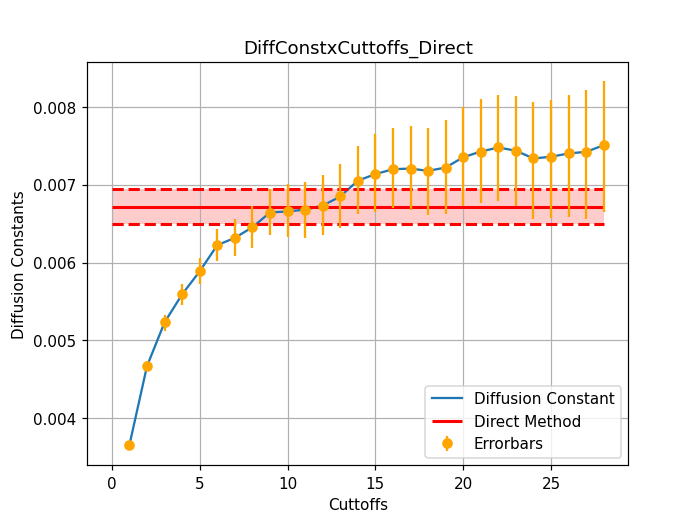

In [260]:
# Graphing mean D across the cutoffs with mean Direct D value
x_shade = list(x)
x_shade.insert(0,0)

fig, ax = plt.subplots()
ax.plot(x,y, label = 'Diffusion Constant') # Graphing the D across cutoffs
ax.hlines(y= D_mean, xmin=0, xmax=28, label = 'Direct Method',color = 'r', linewidth = 2) #solid red line for mean Direct D value
ax.hlines(y=ymin, xmin=0, xmax=28, color = 'r', linestyle = '--', linewidth = 2)#bottom min of cofidence interval
ax.hlines(y=ymax, xmin=0, xmax=28, color = 'r', linestyle = '--', linewidth = 2)#top max of confidence interval
ax.fill_between(x_shade,ymin,ymax,facecolor='red',alpha = 0.2)#shading between the min and max
ax.errorbar(x,y, yerr=y_error,fmt='o',color= 'orange',label = 'Errorbars')#error bars on each D
ax.set_xlabel("Cuttoffs")
ax.set_ylabel("Diffusion Constants")
ax.set_title("DiffConstxCuttoffs_Direct")
ax.legend(loc = 'lower right')
ax.grid()
plt.show()

<IPython.core.display.Javascript object>


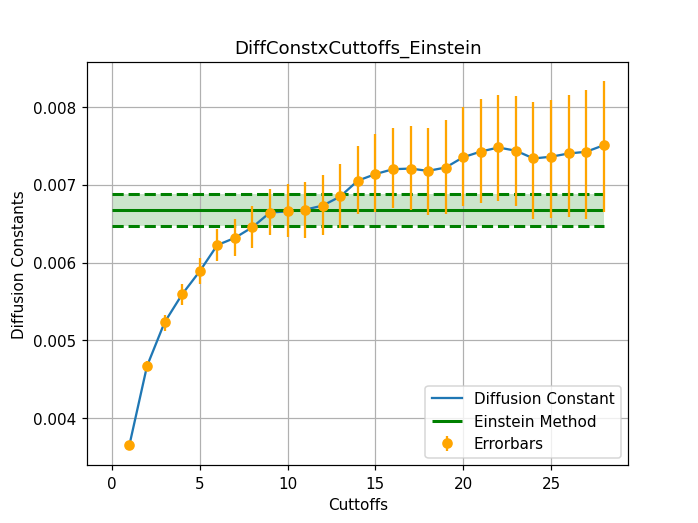

In [259]:
#Graphing mean D across the cutoffs with mean Einstein D value
x_shade = list(x)
x_shade.insert(0,0)

fig, ax = plt.subplots()
ax.plot(x,y, label = 'Diffusion Constant') #Graphing the D across cutoffs
ax.hlines(y= E_mean, xmin=0, xmax=28, label = 'Einstein Method',color = 'green', linewidth = 2)#solid green line for mean Einstein D value
ax.hlines(y=eymin, xmin=0, xmax=28, color = 'green', linestyle = '--', linewidth = 2)#bottom min of cofidence interval
ax.hlines(y=eymax, xmin=0, xmax=28, color = 'green', linestyle = '--', linewidth = 2)#top max of confidence interval
ax.fill_between(x_shade,eymin,eymax,facecolor='green',alpha = 0.2)#shading between the min and max
ax.errorbar(x,y, yerr=y_error,fmt='o',color= 'orange',label = 'Errorbars')#error bars on each D
ax.set_xlabel("Cuttoffs")
ax.set_ylabel("Diffusion Constants")
ax.set_title("DiffConstxCuttoffs_Einstein")
ax.legend(loc = 'lower right')
ax.grid()
plt.show()

<IPython.core.display.Javascript object>


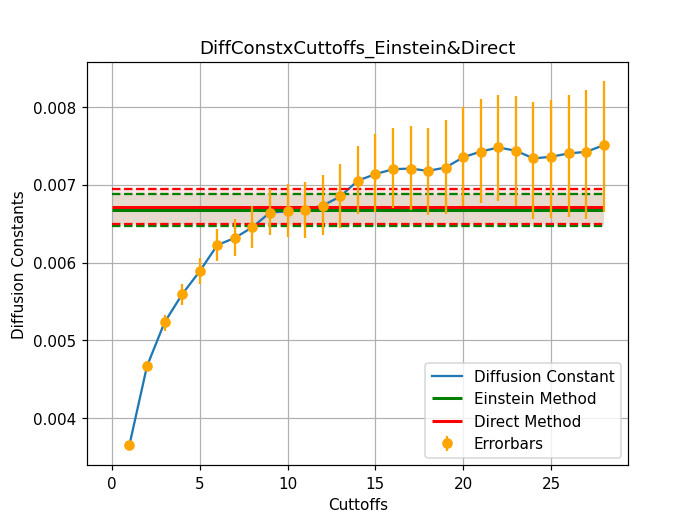

In [258]:
#Graphing mean D across the cutoffs with mean Einstein D value AND Direct D value

x_shade = list(x)
x_shade.insert(0,0)

fig, ax = plt.subplots()
ax.plot(x,y, label = 'Diffusion Constant')
ax.hlines(y= E_mean, xmin=0, xmax=28, label = 'Einstein Method',color = 'green', linewidth = 2)
ax.hlines(y=eymin, xmin=0, xmax=28, color = 'green', linestyle = '--', linewidth = 1.5)
ax.hlines(y=eymax, xmin=0, xmax=28, color = 'green', linestyle = '--', linewidth = 1.5)
ax.fill_between(x_shade,eymin,eymax,facecolor='green',alpha = 0.1)
ax.hlines(y= D_mean, xmin=0, xmax=28, label = 'Direct Method',color = 'r', linewidth = 2)
ax.hlines(y=ymin, xmin=0, xmax=28, color = 'r', linestyle = '--', linewidth = 1.5)
ax.hlines(y=ymax, xmin=0, xmax=28, color = 'r', linestyle = '--', linewidth = 1.5)
ax.fill_between(x_shade,ymin,ymax,facecolor='r',alpha = 0.1)
ax.errorbar(x,y, yerr=y_error,fmt='o',color= 'orange',label = 'Errorbars')
ax.set_xlabel("Cuttoffs")
ax.set_ylabel("Diffusion Constants")
ax.set_title("DiffConstxCuttoffs_Einstein&Direct")
ax.legend(loc = 'lower right')
ax.grid()
plt.show()

## Graphing Auto Correlation Functions

### Starting with v_acf_mz

In [210]:
acf_mz = defaultdict(list)
for dic in holder['v_acf']:
    for key,value in dic.items():
        acf_mz[key].append(value)     
acf_mz = dict(acf_mz)

In [211]:
min_cut = acf_mz[5] # a point below the "perfect" shaded spot
good_cut = acf_mz[10] # a point in the "perfect" shaded spot
max_cut = acf_mz[20] # a point above the "perfect" shaded spot

In [205]:
min_means = np.array([np.mean([i[j] for i in min_cut]) for j in range(len(min_cut[0]))])
good_means = np.array([np.mean([i[j] for i in good_cut]) for j in range(len(good_cut[0]))])
max_means = np.array([np.mean([i[j] for i in max_cut]) for j in range(len(max_cut[0]))])

In [209]:
min_lists = [[i[j] for i in min_cut] for j in range(len(min_cut[0]))]
good_lists = [[i[j] for i in good_cut] for j in range(len(good_cut[0]))]
max_lists = [[i[j] for i in max_cut] for j in range(len(max_cut[0]))]

In [213]:
min_conf = []
for i in min_lists:
    min_conf.append([sorted(i)[CI_index],sorted(i)[-(CI_index+1)]])
    
good_conf = []
for i in good_lists:
    good_conf.append([sorted(i)[CI_index],sorted(i)[-(CI_index+1)]])
    
max_conf = []
for i in max_lists:
    max_conf.append([sorted(i)[CI_index],sorted(i)[-(CI_index+1)]])

In [231]:
min_means[0]

0.012492383592524253

In [232]:
min_conf[0]

[0.012472602495915776, 0.012511327890883805]

In [214]:
# correlation of min
mincut_ermin = [i[0] for i in min_conf]# for shading
mincut_ermax = [i[1] for i in min_conf]# for shading

mincut_errmin = [abs(i-j) for i,j in zip(mincut_ermin,min_means)]# for errorbars
mincut_errmax = [abs(i-j) for i,j in zip(mincut_ermax,min_means)]# for errorbars
mincut_error = np.array([mincut_errmin,mincut_errmax])# for errorbars

# correlation of good
goodcut_ermin = [i[0] for i in good_conf]# for shading
goodcut_ermax = [i[1] for i in good_conf]# for shading

goodcut_errmin = [abs(i-j) for i,j in zip(goodcut_ermin,good_means)]# for errorbars
goodcut_errmax = [abs(i-j) for i,j in zip(goodcut_ermax,good_means)]# for errorbars
goodcut_error = np.array([goodcut_errmin,goodcut_errmax])# for errorbars

#correlation of max
maxcut_ermin = [i[0] for i in max_conf]# for shading
maxcut_ermax = [i[1] for i in max_conf]# for shading

maxcut_errmin = [abs(i-j) for i,j in zip(maxcut_ermin,max_means)]# for errorbars
maxcut_errmax = [abs(i-j) for i,j in zip(maxcut_ermax,max_means)]# for errorbars
maxcut_error = np.array([maxcut_errmin,maxcut_errmax])# for errorbars

<IPython.core.display.Javascript object>


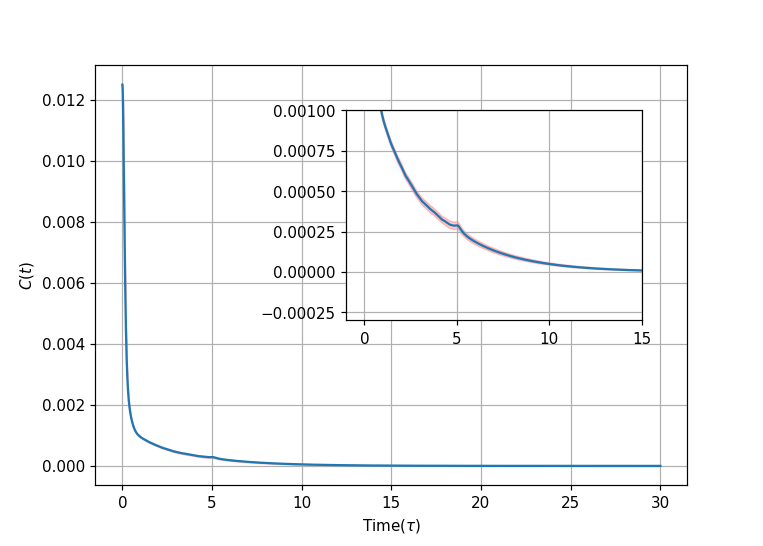

In [240]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel("Time($\\tau$)")
ax.set_ylabel("$C(t)$")
ax.plot(time,min_means,label = 'mincut_AutoCorrelationFunction')
ax.fill_between(time,mincut_ermax,mincut_ermin,color = 'r', alpha = 0.2)
ax.grid()

inset = inset_axes(ax, width='50%',height='50%',loc='upper right',borderpad=3)
inset.plot(time,min_means,label = 'goodcut_AutoCorrelationFunction')
inset.fill_between(time,mincut_ermax,mincut_ermin,color = 'r', alpha = 0.2)
inset.set_xlim(-1,15)
inset.set_ylim(-0.0003,0.001)
inset.grid()

plt.show()

<IPython.core.display.Javascript object>


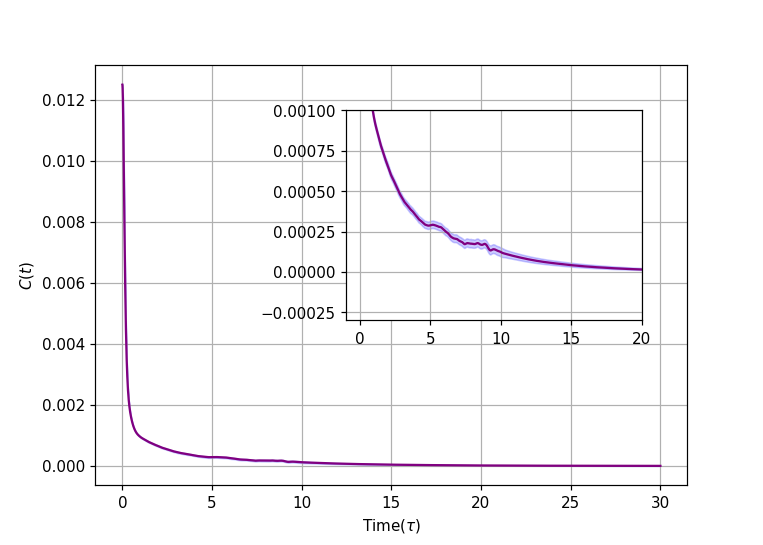

In [245]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel("Time($\\tau$)")
ax.set_ylabel("$C(t)$")
ax.plot(time,good_means,label = 'goodcut_AutoCorrelationFunction',color = 'purple')
ax.fill_between(time,goodcut_ermax,goodcut_ermin,color = 'blue', alpha = 0.2)
ax.grid()

inset = inset_axes(ax, width='50%',height='50%',loc='upper right',borderpad=3)
inset.plot(time,good_means,label = 'goodcut_AutoCorrelationFunction',color = 'purple')
inset.fill_between(time,goodcut_ermax,goodcut_ermin,color = 'blue', alpha = 0.2)
inset.set_xlim(-1,20)
inset.set_ylim(-0.0003,0.001)
inset.grid()

plt.show()

<IPython.core.display.Javascript object>


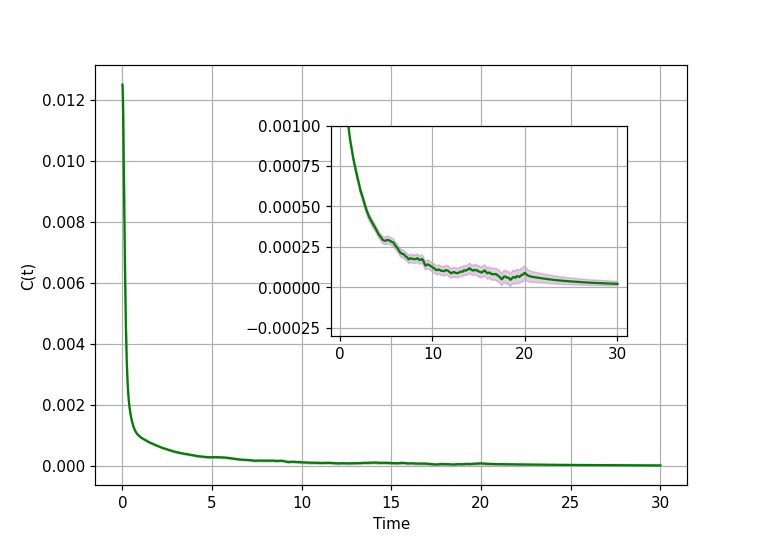

In [257]:
fig, ax = plt.subplots(figsize=(7,5))

ax.plot(time,max_means, label = 'maxcut_CorrelationFunction', color = 'green')
ax.fill_between(time,maxcut_ermin,maxcut_ermax,color='purple',alpha=0.2)
#ax.set_title("Vf_CorrelationFunctionXTime")
ax.set_xlabel("Time")
ax.set_ylabel("C(t)")
ax.grid()

inset = inset_axes(ax, width='50%',height='50%',loc='upper right',borderpad=4)
inset.plot(time,max_means, label = 'maxcut_CorrelationFunction', color = 'green')
inset.fill_between(time,maxcut_ermin,maxcut_ermax,color='purple',alpha=0.2)
inset.set_xlim(-1,31)
inset.set_ylim(-0.0003,0.001)
inset.grid()
plt.show()

### Correlation Functions direct way

In [150]:
corr_v = []
for i in holder['Correlation_Func']:
    corr_v.append(i[0])
        
corr_f = []
for i in holder['Correlation_Func']:
    corr_f.append(i[1])

corr_vf = []
for i in holder['Correlation_Func']:
    corr_vf.append(i[2])

In [152]:
corrv_means = np.array([np.mean([i[j] for i in corr_v]) for j in range(len(corr_v[0]))])
corrf_means = np.array([np.mean([i[j] for i in corr_f]) for j in range(len(corr_f[0]))])
corrvf_means = np.array([np.mean([i[j] for i in corr_vf]) for j in range(len(corr_vf[0]))])

In [153]:
corrv_lists = [[i[j] for i in corr_v] for j in range(len(corr_v[0]))]
corrf_lists = [[i[j] for i in corr_f] for j in range(len(corr_f[0]))]
corrvf_lists = [[i[j] for i in corr_vf] for j in range(len(corr_vf[0]))]

In [154]:
corrv_conf = []
for i in corrv_lists:
    corrv_conf.append([sorted(i)[CI_index],sorted(i)[-(CI_index+1)]])
    
corrf_conf = []
for i in corrf_lists:
    corrf_conf.append([sorted(i)[CI_index],sorted(i)[-(CI_index+1)]])
    
corrvf_conf = []
for i in corrvf_lists:
    corrvf_conf.append([sorted(i)[CI_index],sorted(i)[-(CI_index+1)]])

In [155]:
# correlation of v
cvy_ermin = [i[0] for i in corrv_conf]# for shading
cvy_ermax = [i[1] for i in corrv_conf]# for shading

cvy_errmin = [abs(i-j) for i,j in zip(cvy_ermin,corrv_means)]# for errorbars
cvy_errmax = [abs(i-j) for i,j in zip(cvy_ermax,corrv_means)]# for errorbars
cvy_error = np.array([cvy_errmin,cvy_errmax])# for errorbars

# correlation of f
cfy_ermin = [i[0] for i in corrf_conf]# for shading
cfy_ermax = [i[1] for i in corrf_conf]# for shading

cfy_errmin = [abs(i-j) for i,j in zip(cfy_ermin,corrf_means)]# for errorbars
cfy_errmax = [abs(i-j) for i,j in zip(cfy_ermax,corrf_means)]# for errorbars
cfy_error = np.array([cvy_errmin,cvy_errmax])# for errorbars

#correlation of vf
cvfy_ermin = [i[0] for i in corrvf_conf]# for shading
cvfy_ermax = [i[1] for i in corrvf_conf]# for shading

cvfy_errmin = [abs(i-j) for i,j in zip(cvfy_ermin,corrvf_means)]# for errorbars
cvfy_errmax = [abs(i-j) for i,j in zip(cvfy_ermax,corrvf_means)]# for errorbars
cvfy_error = np.array([cvy_errmin,cvy_errmax])# for errorbars

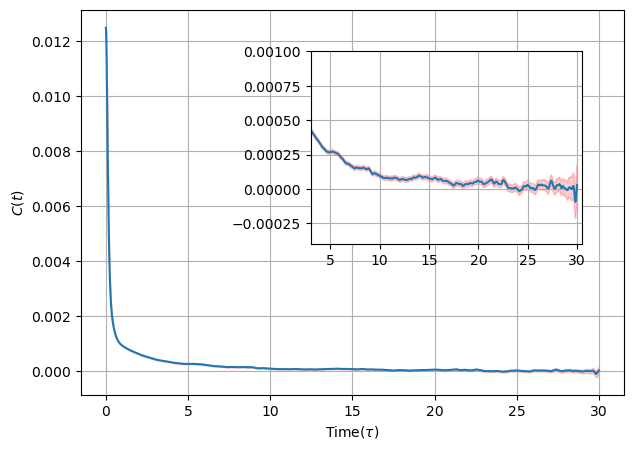

In [226]:

fig, ax = plt.subplots(figsize=(7,5))
#ax2.plot(time,corrv_means,label = 'V_AutoCorrelationFunction')
#ax.errorbar(time,corrv_means,yerr=cvy_error)
#ax.plot(time, cvy_ermax, linestyle = '--',label = 'upper_limit')
#ax.plot(time, cvy_ermin, linestyle = '--',label = 'lower_limit')
#inset = ax2.fill_between(time,cvy_ermax,cvy_ermin,color = 'r', alpha = 0.2)
ax.set_xlabel("Time($\\tau$)")
ax.set_ylabel("$C(t)$")
ax.plot(time,corrv_means,label = 'V_AutoCorrelationFunction')
ax.fill_between(time,cvy_ermax,cvy_ermin,color = 'r', alpha = 0.2)
ax.grid()

inset = inset_axes(ax, width='50%',height='50%',loc='upper right',borderpad=3)
inset.plot(time,corrv_means,label = 'V_AutoCorrelationFunction')
inset.fill_between(time,cvy_ermax,cvy_ermin,color = 'r', alpha = 0.2)
inset.set_xlim(3,30.5)
inset.set_ylim(-0.0004,0.0010)
inset.grid()

plt.show()

<IPython.core.display.Javascript object>


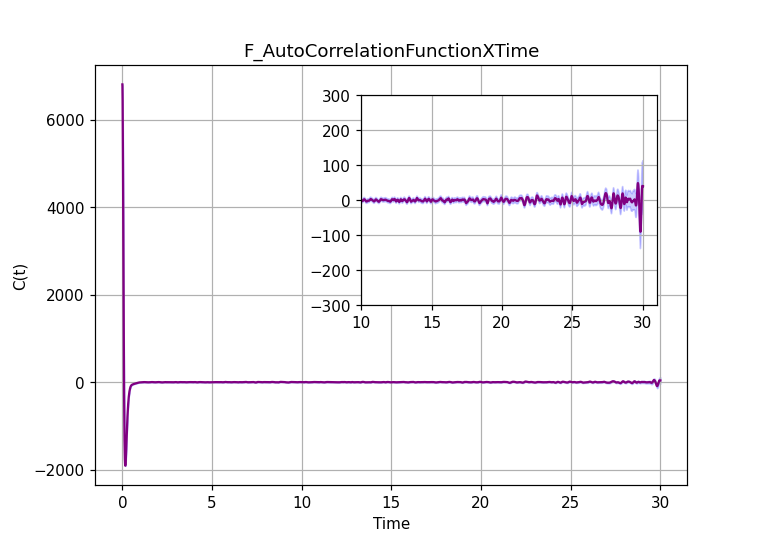

In [247]:
fig, ax = plt.subplots(figsize=(7,5))

ax.plot(time,corrf_means, label = 'F_AutoCorrelationFunction', color = 'purple')
ax.fill_between(time,cfy_ermin,cfy_ermax, color = 'blue', alpha = 0.2)
ax.set_title("F_AutoCorrelationFunctionXTime")
ax.set_xlabel("Time")
ax.set_ylabel("C(t)")
ax.grid()

inset = inset_axes(ax, width='50%',height='50%',loc = 'upper right',borderpad=2)
inset.plot(time,corrf_means, label = 'F_AutoCorrelationFunction', color = 'purple')
inset.fill_between(time,cfy_ermin,cfy_ermax, color = 'blue', alpha = 0.2)
inset.set_xlim(10,31)
inset.set_ylim(-300,300)
inset.grid()
plt.show()

<IPython.core.display.Javascript object>


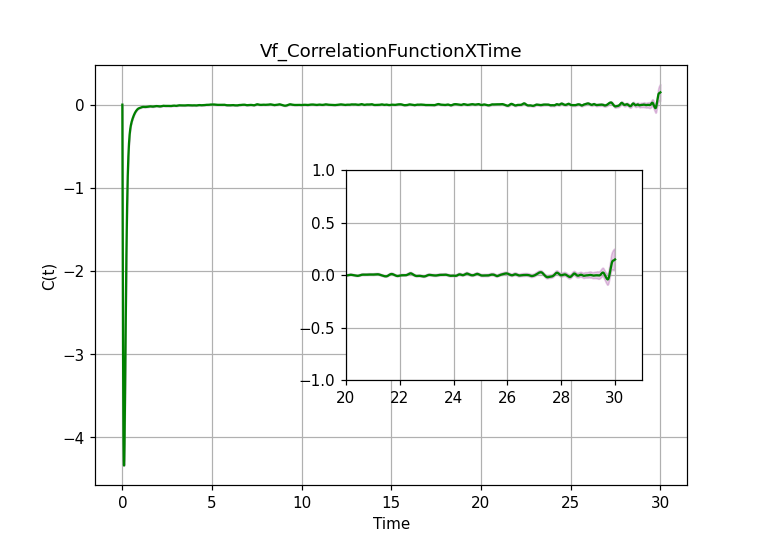

In [246]:
fig, ax = plt.subplots(figsize=(7,5))

ax.plot(time,corrvf_means, label = 'vF_CorrelationFunction', color = 'green')
ax.fill_between(time,cvfy_ermin,cvfy_ermax,color='purple',alpha=0.2)
ax.set_title("Vf_CorrelationFunctionXTime")
ax.set_xlabel("Time")
ax.set_ylabel("C(t)")
ax.grid()

inset = inset_axes(ax, width='50%',height='50%',loc='center right',borderpad=3)
inset.plot(time,corrvf_means, label = 'vF_CorrelationFunction', color = 'green')
inset.fill_between(time,cvfy_ermin,cvfy_ermax,color='purple',alpha=0.2)
inset.set_xlim(20,31) 
inset.set_ylim(-1,1)
inset.grid()
plt.show()

## Graphin K Values

In [168]:
K_Values = holder['K_Values']
K1_Values = holder['K1_Values']
K3_Values = holder['K3_Values']

In [169]:
k_means = [np.mean([i[j] for i in K_Values]) for j in range(len(K_Values[0]))]
k1_means = [np.mean([i[j] for i in K1_Values]) for j in range(len(K1_Values[0]))]
k3_means = [np.mean([i[j] for i in K3_Values]) for j in range(len(K3_Values[0]))]

In [173]:
k_lists = [[i[j] for i in K_Values] for j in range(len(K_Values[0]))]
k1_lists = [[i[j] for i in K1_Values] for j in range(len(K1_Values[0]))]
k3_lists = [[i[j] for i in K3_Values] for j in range(len(K3_Values[0]))]

In [172]:
k_conf = []
for i in k_lists:
    k_conf.append([sorted(i)[CI_index],sorted(i)[-(CI_index+1)]])
    
k1_conf = []
for i in k1_lists:
    k1_conf.append([sorted(i)[CI_index],sorted(i)[-(CI_index+1)]])
    
k3_conf = []
for i in k3_lists:
    k3_conf.append([sorted(i)[CI_index],sorted(i)[-(CI_index+1)]])

In [174]:
ky_ermin = [i[0] for i in k_conf]# for shading
ky_ermax = [i[1] for i in k_conf]# for shading

k1y_ermin = [i[0] for i in k1_conf]# for shading
k1y_ermax = [i[1] for i in k1_conf]# for shading

k3y_ermin = [i[0] for i in k3_conf]# for shading
k3y_ermax = [i[1] for i in k3_conf]# for shading

<IPython.core.display.Javascript object>


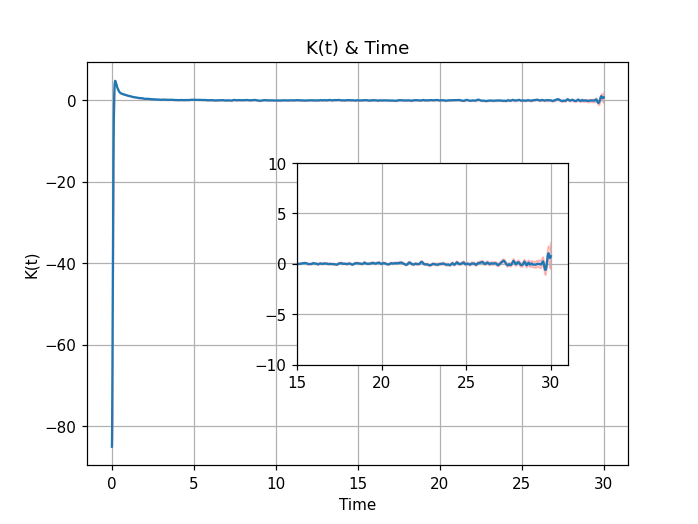

In [248]:
fig,ax = plt.subplots()
ax.plot(time,k_means, label = "K_Values")
ax.fill_between(time,ky_ermin,ky_ermax,color='r',alpha=0.2)
ax.set_title("K(t) & Time")
ax.set_xlabel("Time")
ax.set_ylabel("K(t)")
ax.grid()

inset = inset_axes(ax,width='50%',height = '50%',loc='center right',borderpad=4)
inset.plot(time,k_means, label = "K_Values")
inset.fill_between(time,ky_ermin,ky_ermax,color='r',alpha=0.2)
inset.set_xlim(15,31)
inset.set_ylim(-10,10)
inset.grid()
plt.show()

<IPython.core.display.Javascript object>


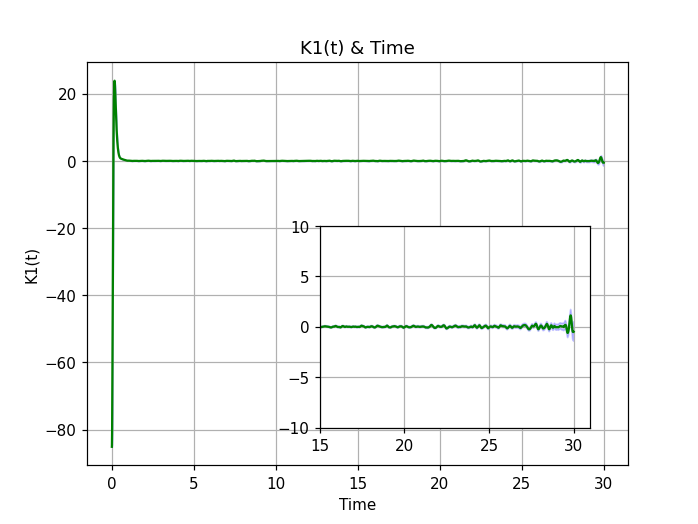

In [249]:
fig,ax = plt.subplots()
ax.plot(time,k1_means,label="K1_Values",color = 'green')
ax.fill_between(time,k1y_ermin,k1y_ermax,color='blue',alpha=0.2)
ax.set_title("K1(t) & Time")
ax.set_xlabel("Time")
ax.set_ylabel("K1(t)")
ax.grid()

inset = inset_axes(ax,width='50%',height='50%',loc='lower right',borderpad=2.5)
inset.plot(time,k1_means,label="K1_Values",color = 'green')
inset.fill_between(time,k1y_ermin,k1y_ermax,color='blue',alpha=0.2)
#inset.set_yticks([])
#inset.set_xticks([])
inset.set_xlim(15,31)
inset.set_ylim(-10,10)
inset.grid()
plt.show()

<IPython.core.display.Javascript object>


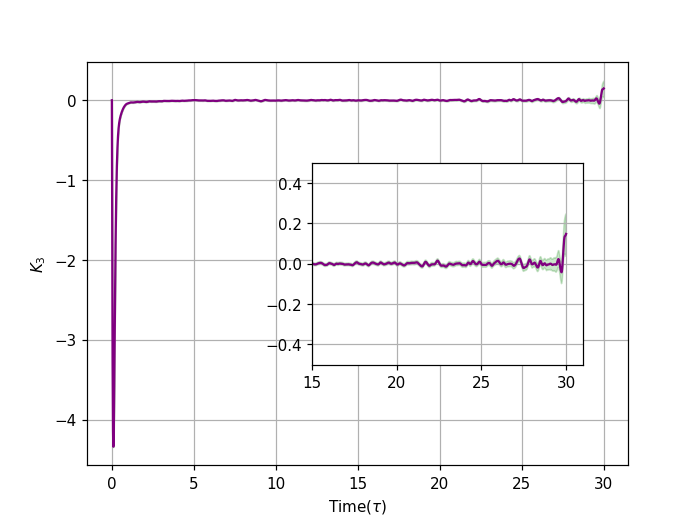

In [250]:
fig,ax = plt.subplots()
ax.plot(time,k3_means,label="K3_Values",color = 'purple')
ax.fill_between(time,k3y_ermin,k3y_ermax,color='green',alpha=0.2)
ax.set_xlabel("Time($\\tau$)")
ax.set_ylabel("$K_3$")
ax.grid()

inset = inset_axes(ax,width='50%',height='50%',loc='center right',borderpad=3)
inset.plot(time,k3_means,label="K3_Values",color = 'purple')
inset.fill_between(time,k3y_ermin,k3y_ermax,color='green',alpha=0.2)
inset.set_xlim(15,31)
inset.set_ylim(-0.5,0.5)
inset.grid()
plt.show()

# Graphing differences of D

<IPython.core.display.Javascript object>


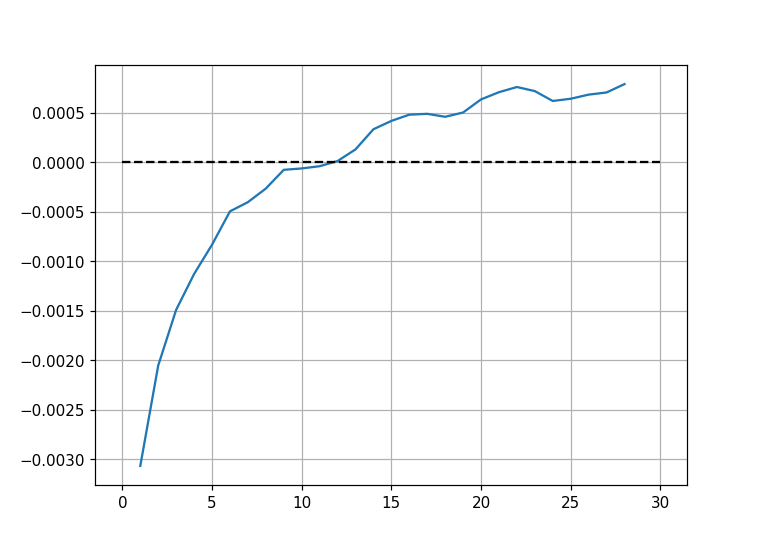

In [307]:
diff_dic = defaultdict(list)
for key,value in mz_dict.items():
    diff_dic[key].append(value-D_mean)
diff_dic = dict(diff_dic)


diff_list = []
for key,value in diff_dic.items():
    diff_list.append(np.mean(value))

    
x = cutoffs.ravel() # ravel flattens the array to be 1D without changin the order
y = np.array(diff_list).ravel()

fig,ax = plt.subplots(figsize=(7,5))
ax.plot(x,y,label='Delta D')
ax.hlines(0,xmin=0,xmax=30,color='black',linestyle='--')
ax.grid()
plt.show()